# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

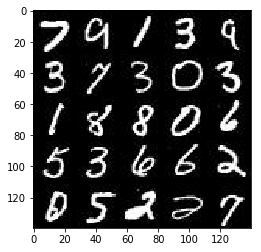

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

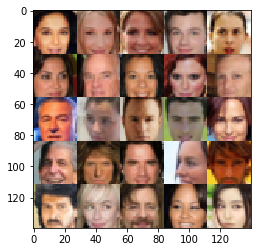

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None ,image_width, image_height, image_channels), name='input')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        
        out = tf.tanh(logits)
        
    return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_images, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_images, z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    number_of_sample = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_n = 1
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_images: batch_images, z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_images: batch_images, z: batch_z, lr:learning_rate})
                if batch_n % 10 == 0:
                    train_loss_d = d_loss.eval({z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "batch {}...".format(batch_n),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batch_n % 100 == 0:
                    show_generator_output(sess, number_of_sample, z, data_shape[3], data_image_mode)
                    
                batch_n += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... batch 10... Discriminator Loss: 3.1494... Generator Loss: 4.6626
Epoch 1/2... batch 20... Discriminator Loss: 3.0380... Generator Loss: 5.6328
Epoch 1/2... batch 30... Discriminator Loss: 2.9061... Generator Loss: 2.5326
Epoch 1/2... batch 40... Discriminator Loss: 2.5014... Generator Loss: 2.4665
Epoch 1/2... batch 50... Discriminator Loss: 2.2282... Generator Loss: 1.9110
Epoch 1/2... batch 60... Discriminator Loss: 1.9521... Generator Loss: 1.6399
Epoch 1/2... batch 70... Discriminator Loss: 2.2165... Generator Loss: 2.0941
Epoch 1/2... batch 80... Discriminator Loss: 1.8167... Generator Loss: 1.4221
Epoch 1/2... batch 90... Discriminator Loss: 1.9351... Generator Loss: 1.6425
Epoch 1/2... batch 100... Discriminator Loss: 1.6831... Generator Loss: 2.2575


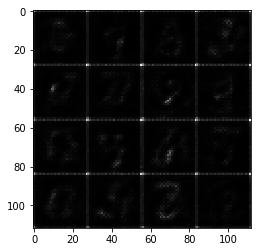

Epoch 1/2... batch 110... Discriminator Loss: 1.6686... Generator Loss: 1.8857
Epoch 1/2... batch 120... Discriminator Loss: 1.5650... Generator Loss: 1.5455
Epoch 1/2... batch 130... Discriminator Loss: 1.3301... Generator Loss: 3.2748
Epoch 1/2... batch 140... Discriminator Loss: 1.3699... Generator Loss: 1.8424
Epoch 1/2... batch 150... Discriminator Loss: 1.2150... Generator Loss: 1.9211
Epoch 1/2... batch 160... Discriminator Loss: 1.5284... Generator Loss: 1.9389
Epoch 1/2... batch 170... Discriminator Loss: 1.4172... Generator Loss: 2.3148
Epoch 1/2... batch 180... Discriminator Loss: 0.9943... Generator Loss: 2.2835
Epoch 1/2... batch 190... Discriminator Loss: 1.2780... Generator Loss: 2.2411
Epoch 1/2... batch 200... Discriminator Loss: 1.0940... Generator Loss: 1.9545


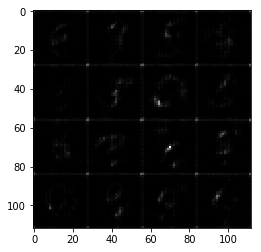

Epoch 1/2... batch 210... Discriminator Loss: 0.8920... Generator Loss: 1.7647
Epoch 1/2... batch 220... Discriminator Loss: 1.1738... Generator Loss: 1.8268
Epoch 1/2... batch 230... Discriminator Loss: 1.0998... Generator Loss: 1.9266
Epoch 1/2... batch 240... Discriminator Loss: 1.0451... Generator Loss: 1.9268
Epoch 1/2... batch 250... Discriminator Loss: 0.9550... Generator Loss: 1.1970
Epoch 1/2... batch 260... Discriminator Loss: 1.2282... Generator Loss: 1.9255
Epoch 1/2... batch 270... Discriminator Loss: 1.2630... Generator Loss: 1.7419
Epoch 1/2... batch 280... Discriminator Loss: 1.5316... Generator Loss: 2.3538
Epoch 1/2... batch 290... Discriminator Loss: 0.9422... Generator Loss: 1.8528
Epoch 1/2... batch 300... Discriminator Loss: 1.4356... Generator Loss: 1.6139


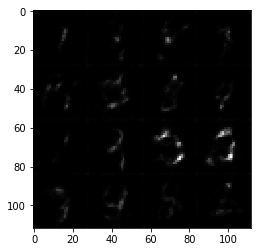

Epoch 1/2... batch 310... Discriminator Loss: 1.5428... Generator Loss: 1.6650
Epoch 1/2... batch 320... Discriminator Loss: 1.2174... Generator Loss: 2.0611
Epoch 1/2... batch 330... Discriminator Loss: 1.0430... Generator Loss: 1.7510
Epoch 1/2... batch 340... Discriminator Loss: 1.3771... Generator Loss: 1.7531
Epoch 1/2... batch 350... Discriminator Loss: 1.1135... Generator Loss: 1.6922
Epoch 1/2... batch 360... Discriminator Loss: 1.3570... Generator Loss: 1.6282
Epoch 1/2... batch 370... Discriminator Loss: 1.6201... Generator Loss: 1.7914
Epoch 1/2... batch 380... Discriminator Loss: 1.4373... Generator Loss: 1.5105
Epoch 1/2... batch 390... Discriminator Loss: 1.3872... Generator Loss: 1.4277
Epoch 1/2... batch 400... Discriminator Loss: 1.3399... Generator Loss: 1.0734


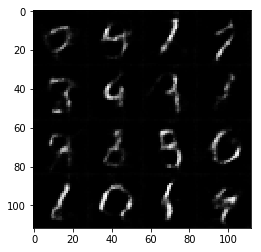

Epoch 1/2... batch 410... Discriminator Loss: 1.2952... Generator Loss: 1.6836
Epoch 1/2... batch 420... Discriminator Loss: 1.1270... Generator Loss: 1.2809
Epoch 1/2... batch 430... Discriminator Loss: 1.5934... Generator Loss: 1.7189
Epoch 1/2... batch 440... Discriminator Loss: 1.1164... Generator Loss: 1.2227
Epoch 1/2... batch 450... Discriminator Loss: 1.0780... Generator Loss: 1.4923
Epoch 1/2... batch 460... Discriminator Loss: 1.0790... Generator Loss: 1.4043
Epoch 1/2... batch 470... Discriminator Loss: 1.3770... Generator Loss: 1.5796
Epoch 1/2... batch 480... Discriminator Loss: 1.3591... Generator Loss: 1.6922
Epoch 1/2... batch 490... Discriminator Loss: 1.3981... Generator Loss: 1.5355
Epoch 1/2... batch 500... Discriminator Loss: 1.3436... Generator Loss: 1.4768


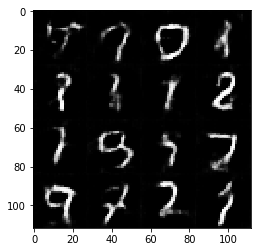

Epoch 1/2... batch 510... Discriminator Loss: 1.3782... Generator Loss: 0.5961
Epoch 1/2... batch 520... Discriminator Loss: 1.7214... Generator Loss: 0.3250
Epoch 1/2... batch 530... Discriminator Loss: 1.5574... Generator Loss: 0.4256
Epoch 1/2... batch 540... Discriminator Loss: 1.7202... Generator Loss: 0.3333
Epoch 1/2... batch 550... Discriminator Loss: 1.5142... Generator Loss: 0.4358
Epoch 1/2... batch 560... Discriminator Loss: 1.7514... Generator Loss: 0.3169
Epoch 1/2... batch 570... Discriminator Loss: 1.5359... Generator Loss: 0.4432
Epoch 1/2... batch 580... Discriminator Loss: 1.7071... Generator Loss: 0.3255
Epoch 1/2... batch 590... Discriminator Loss: 1.7587... Generator Loss: 0.3158
Epoch 1/2... batch 600... Discriminator Loss: 1.3643... Generator Loss: 0.5377


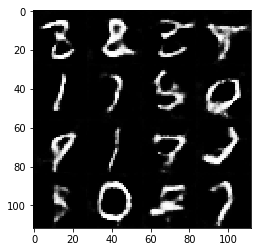

Epoch 1/2... batch 610... Discriminator Loss: 1.6005... Generator Loss: 0.3699
Epoch 1/2... batch 620... Discriminator Loss: 1.4391... Generator Loss: 0.5024
Epoch 1/2... batch 630... Discriminator Loss: 1.8822... Generator Loss: 0.2903
Epoch 1/2... batch 640... Discriminator Loss: 1.6748... Generator Loss: 0.3514
Epoch 1/2... batch 650... Discriminator Loss: 1.6901... Generator Loss: 0.3442
Epoch 1/2... batch 660... Discriminator Loss: 1.6002... Generator Loss: 0.3751
Epoch 1/2... batch 670... Discriminator Loss: 1.2249... Generator Loss: 0.7283
Epoch 1/2... batch 680... Discriminator Loss: 1.5811... Generator Loss: 0.4094
Epoch 1/2... batch 690... Discriminator Loss: 1.6543... Generator Loss: 0.3657
Epoch 1/2... batch 700... Discriminator Loss: 1.5757... Generator Loss: 0.3800


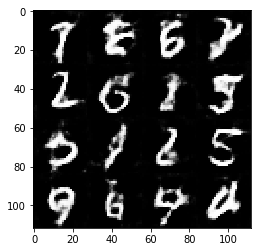

Epoch 1/2... batch 710... Discriminator Loss: 1.7181... Generator Loss: 0.3520
Epoch 1/2... batch 720... Discriminator Loss: 1.3149... Generator Loss: 0.6684
Epoch 1/2... batch 730... Discriminator Loss: 1.9759... Generator Loss: 0.2381
Epoch 1/2... batch 740... Discriminator Loss: 1.3878... Generator Loss: 0.5315
Epoch 1/2... batch 750... Discriminator Loss: 1.2696... Generator Loss: 0.6416
Epoch 1/2... batch 760... Discriminator Loss: 1.7234... Generator Loss: 0.3166
Epoch 1/2... batch 770... Discriminator Loss: 1.4598... Generator Loss: 0.4739
Epoch 1/2... batch 780... Discriminator Loss: 1.2975... Generator Loss: 0.5631
Epoch 1/2... batch 790... Discriminator Loss: 1.4691... Generator Loss: 0.4468
Epoch 1/2... batch 800... Discriminator Loss: 1.7302... Generator Loss: 0.3208


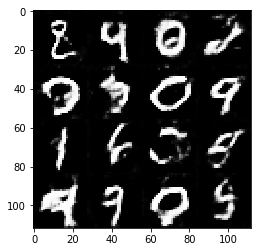

Epoch 1/2... batch 810... Discriminator Loss: 1.5067... Generator Loss: 0.4360
Epoch 1/2... batch 820... Discriminator Loss: 1.1508... Generator Loss: 1.0039
Epoch 1/2... batch 830... Discriminator Loss: 2.0708... Generator Loss: 2.6965
Epoch 1/2... batch 840... Discriminator Loss: 1.2202... Generator Loss: 0.7720
Epoch 1/2... batch 850... Discriminator Loss: 1.5176... Generator Loss: 0.4221
Epoch 1/2... batch 860... Discriminator Loss: 1.5803... Generator Loss: 0.3891
Epoch 1/2... batch 870... Discriminator Loss: 1.6191... Generator Loss: 0.4008
Epoch 1/2... batch 880... Discriminator Loss: 1.5316... Generator Loss: 0.4095
Epoch 1/2... batch 890... Discriminator Loss: 1.4958... Generator Loss: 0.4356
Epoch 1/2... batch 900... Discriminator Loss: 2.5545... Generator Loss: 0.1515


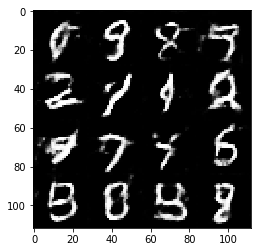

Epoch 1/2... batch 910... Discriminator Loss: 1.4177... Generator Loss: 0.4755
Epoch 1/2... batch 920... Discriminator Loss: 1.4951... Generator Loss: 0.4517
Epoch 1/2... batch 930... Discriminator Loss: 1.6887... Generator Loss: 0.3638
Epoch 2/2... batch 10... Discriminator Loss: 1.2518... Generator Loss: 1.6833
Epoch 2/2... batch 20... Discriminator Loss: 1.2940... Generator Loss: 1.3757
Epoch 2/2... batch 30... Discriminator Loss: 1.1554... Generator Loss: 1.2476
Epoch 2/2... batch 40... Discriminator Loss: 1.1223... Generator Loss: 0.7941
Epoch 2/2... batch 50... Discriminator Loss: 2.5455... Generator Loss: 0.1508
Epoch 2/2... batch 60... Discriminator Loss: 1.3021... Generator Loss: 0.6488
Epoch 2/2... batch 70... Discriminator Loss: 1.1571... Generator Loss: 0.7152
Epoch 2/2... batch 80... Discriminator Loss: 2.0078... Generator Loss: 2.6156
Epoch 2/2... batch 90... Discriminator Loss: 1.1857... Generator Loss: 1.3610
Epoch 2/2... batch 100... Discriminator Loss: 1.0123... Gener

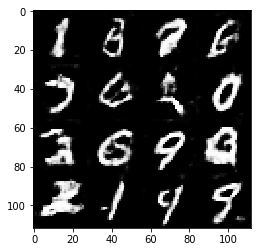

Epoch 2/2... batch 110... Discriminator Loss: 1.6035... Generator Loss: 2.3594
Epoch 2/2... batch 120... Discriminator Loss: 1.2802... Generator Loss: 1.3786
Epoch 2/2... batch 130... Discriminator Loss: 1.7553... Generator Loss: 0.3391
Epoch 2/2... batch 140... Discriminator Loss: 1.0898... Generator Loss: 0.7325
Epoch 2/2... batch 150... Discriminator Loss: 1.0773... Generator Loss: 0.7469
Epoch 2/2... batch 160... Discriminator Loss: 1.1884... Generator Loss: 1.3511
Epoch 2/2... batch 170... Discriminator Loss: 1.1644... Generator Loss: 1.4749
Epoch 2/2... batch 180... Discriminator Loss: 1.3329... Generator Loss: 0.5605
Epoch 2/2... batch 190... Discriminator Loss: 2.2010... Generator Loss: 0.1985
Epoch 2/2... batch 200... Discriminator Loss: 1.7421... Generator Loss: 0.3264


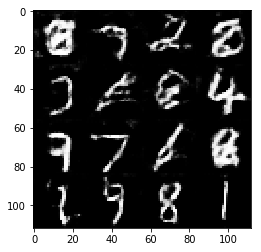

Epoch 2/2... batch 210... Discriminator Loss: 1.5661... Generator Loss: 0.4115
Epoch 2/2... batch 220... Discriminator Loss: 1.1750... Generator Loss: 0.7261
Epoch 2/2... batch 230... Discriminator Loss: 1.5783... Generator Loss: 0.4025
Epoch 2/2... batch 240... Discriminator Loss: 1.5138... Generator Loss: 0.4317
Epoch 2/2... batch 250... Discriminator Loss: 1.5609... Generator Loss: 0.4271
Epoch 2/2... batch 260... Discriminator Loss: 1.2706... Generator Loss: 0.5733
Epoch 2/2... batch 270... Discriminator Loss: 1.5507... Generator Loss: 0.4185
Epoch 2/2... batch 280... Discriminator Loss: 1.6374... Generator Loss: 0.3770
Epoch 2/2... batch 290... Discriminator Loss: 1.6910... Generator Loss: 0.3834
Epoch 2/2... batch 300... Discriminator Loss: 1.1083... Generator Loss: 1.1342


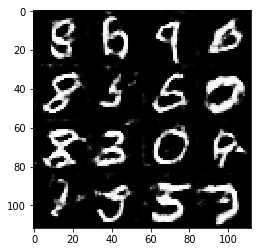

Epoch 2/2... batch 310... Discriminator Loss: 2.2278... Generator Loss: 2.1263
Epoch 2/2... batch 320... Discriminator Loss: 1.1471... Generator Loss: 1.2459
Epoch 2/2... batch 330... Discriminator Loss: 1.0478... Generator Loss: 1.1085
Epoch 2/2... batch 340... Discriminator Loss: 1.2091... Generator Loss: 1.8620
Epoch 2/2... batch 350... Discriminator Loss: 1.0060... Generator Loss: 1.5087
Epoch 2/2... batch 360... Discriminator Loss: 1.1113... Generator Loss: 1.4814
Epoch 2/2... batch 370... Discriminator Loss: 1.2488... Generator Loss: 0.6991
Epoch 2/2... batch 380... Discriminator Loss: 1.3914... Generator Loss: 0.4931
Epoch 2/2... batch 390... Discriminator Loss: 1.1339... Generator Loss: 0.7439
Epoch 2/2... batch 400... Discriminator Loss: 1.7788... Generator Loss: 0.3236


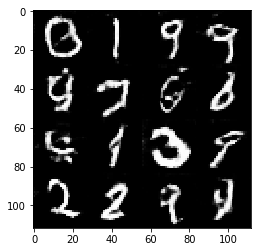

Epoch 2/2... batch 410... Discriminator Loss: 1.1875... Generator Loss: 0.6486
Epoch 2/2... batch 420... Discriminator Loss: 1.6620... Generator Loss: 0.3501
Epoch 2/2... batch 430... Discriminator Loss: 1.6091... Generator Loss: 0.4106
Epoch 2/2... batch 440... Discriminator Loss: 1.2417... Generator Loss: 0.6195
Epoch 2/2... batch 450... Discriminator Loss: 0.9447... Generator Loss: 1.2135
Epoch 2/2... batch 460... Discriminator Loss: 1.5526... Generator Loss: 2.4583
Epoch 2/2... batch 470... Discriminator Loss: 1.3738... Generator Loss: 2.1781
Epoch 2/2... batch 480... Discriminator Loss: 1.4439... Generator Loss: 0.4607
Epoch 2/2... batch 490... Discriminator Loss: 1.6977... Generator Loss: 0.3292
Epoch 2/2... batch 500... Discriminator Loss: 1.4481... Generator Loss: 0.4438


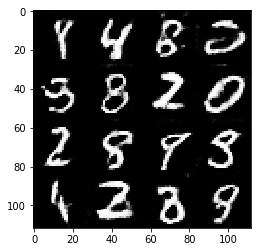

Epoch 2/2... batch 510... Discriminator Loss: 2.3592... Generator Loss: 0.1923
Epoch 2/2... batch 520... Discriminator Loss: 1.2334... Generator Loss: 0.6630
Epoch 2/2... batch 530... Discriminator Loss: 0.9059... Generator Loss: 0.9929
Epoch 2/2... batch 540... Discriminator Loss: 1.4819... Generator Loss: 0.4947
Epoch 2/2... batch 550... Discriminator Loss: 1.7809... Generator Loss: 0.3221
Epoch 2/2... batch 560... Discriminator Loss: 1.0850... Generator Loss: 0.8667
Epoch 2/2... batch 570... Discriminator Loss: 1.0910... Generator Loss: 1.5605
Epoch 2/2... batch 580... Discriminator Loss: 1.3770... Generator Loss: 1.5785
Epoch 2/2... batch 590... Discriminator Loss: 1.5434... Generator Loss: 0.4401
Epoch 2/2... batch 600... Discriminator Loss: 1.3063... Generator Loss: 0.5639


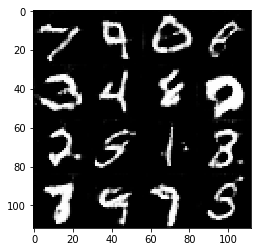

Epoch 2/2... batch 610... Discriminator Loss: 1.2298... Generator Loss: 0.6234
Epoch 2/2... batch 620... Discriminator Loss: 1.3304... Generator Loss: 0.5718
Epoch 2/2... batch 630... Discriminator Loss: 1.7893... Generator Loss: 0.3216
Epoch 2/2... batch 640... Discriminator Loss: 1.5258... Generator Loss: 0.4343
Epoch 2/2... batch 650... Discriminator Loss: 1.2125... Generator Loss: 0.9727
Epoch 2/2... batch 660... Discriminator Loss: 1.2970... Generator Loss: 1.7176
Epoch 2/2... batch 670... Discriminator Loss: 1.1052... Generator Loss: 1.1975
Epoch 2/2... batch 680... Discriminator Loss: 1.6930... Generator Loss: 0.3455
Epoch 2/2... batch 690... Discriminator Loss: 1.1610... Generator Loss: 0.6947
Epoch 2/2... batch 700... Discriminator Loss: 0.9617... Generator Loss: 0.8982


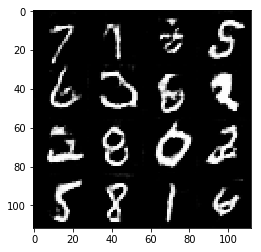

Epoch 2/2... batch 710... Discriminator Loss: 0.8754... Generator Loss: 1.0429
Epoch 2/2... batch 720... Discriminator Loss: 1.4766... Generator Loss: 2.1396
Epoch 2/2... batch 730... Discriminator Loss: 0.8573... Generator Loss: 1.3150
Epoch 2/2... batch 740... Discriminator Loss: 1.1450... Generator Loss: 1.6370
Epoch 2/2... batch 750... Discriminator Loss: 1.0736... Generator Loss: 1.5065
Epoch 2/2... batch 760... Discriminator Loss: 1.2164... Generator Loss: 2.4669
Epoch 2/2... batch 770... Discriminator Loss: 1.4627... Generator Loss: 0.5028
Epoch 2/2... batch 780... Discriminator Loss: 0.8806... Generator Loss: 1.4676
Epoch 2/2... batch 790... Discriminator Loss: 1.1367... Generator Loss: 1.9536
Epoch 2/2... batch 800... Discriminator Loss: 1.6233... Generator Loss: 0.4110


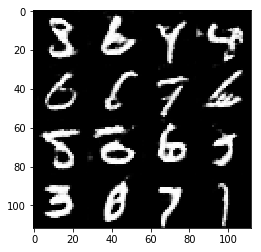

Epoch 2/2... batch 810... Discriminator Loss: 1.1577... Generator Loss: 0.7199
Epoch 2/2... batch 820... Discriminator Loss: 1.1017... Generator Loss: 0.7942
Epoch 2/2... batch 830... Discriminator Loss: 1.4362... Generator Loss: 0.4762
Epoch 2/2... batch 840... Discriminator Loss: 1.7842... Generator Loss: 0.3209
Epoch 2/2... batch 850... Discriminator Loss: 1.0987... Generator Loss: 0.7738
Epoch 2/2... batch 860... Discriminator Loss: 1.4370... Generator Loss: 0.4986
Epoch 2/2... batch 870... Discriminator Loss: 1.1492... Generator Loss: 0.7282
Epoch 2/2... batch 880... Discriminator Loss: 0.9171... Generator Loss: 0.9732
Epoch 2/2... batch 890... Discriminator Loss: 1.0263... Generator Loss: 1.2922
Epoch 2/2... batch 900... Discriminator Loss: 1.0582... Generator Loss: 1.9560


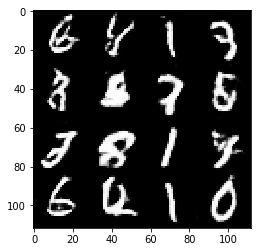

Epoch 2/2... batch 910... Discriminator Loss: 1.6935... Generator Loss: 2.6123
Epoch 2/2... batch 920... Discriminator Loss: 0.8106... Generator Loss: 1.6415
Epoch 2/2... batch 930... Discriminator Loss: 1.0076... Generator Loss: 1.3720


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... batch 10... Discriminator Loss: 4.7246... Generator Loss: 7.0340
Epoch 1/1... batch 20... Discriminator Loss: 2.1630... Generator Loss: 3.8274
Epoch 1/1... batch 30... Discriminator Loss: 1.7268... Generator Loss: 3.5117
Epoch 1/1... batch 40... Discriminator Loss: 1.2981... Generator Loss: 0.6999
Epoch 1/1... batch 50... Discriminator Loss: 0.6381... Generator Loss: 2.2274
Epoch 1/1... batch 60... Discriminator Loss: 2.3565... Generator Loss: 6.4573
Epoch 1/1... batch 70... Discriminator Loss: 1.8793... Generator Loss: 6.1538
Epoch 1/1... batch 80... Discriminator Loss: 4.9278... Generator Loss: 9.6533
Epoch 1/1... batch 90... Discriminator Loss: 0.4483... Generator Loss: 4.4586
Epoch 1/1... batch 100... Discriminator Loss: 1.3582... Generator Loss: 6.6713


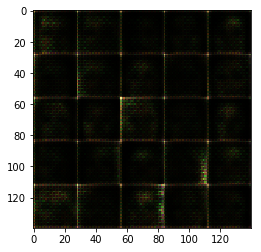

Epoch 1/1... batch 110... Discriminator Loss: 1.1399... Generator Loss: 6.3387
Epoch 1/1... batch 120... Discriminator Loss: 3.1918... Generator Loss: 7.9977
Epoch 1/1... batch 130... Discriminator Loss: 0.9197... Generator Loss: 6.4128
Epoch 1/1... batch 140... Discriminator Loss: 0.6632... Generator Loss: 5.1299
Epoch 1/1... batch 150... Discriminator Loss: 0.5501... Generator Loss: 4.6647
Epoch 1/1... batch 160... Discriminator Loss: 1.0278... Generator Loss: 5.3782
Epoch 1/1... batch 170... Discriminator Loss: 0.8754... Generator Loss: 4.7108
Epoch 1/1... batch 180... Discriminator Loss: 3.1421... Generator Loss: 0.0818
Epoch 1/1... batch 190... Discriminator Loss: 1.3687... Generator Loss: 0.4907
Epoch 1/1... batch 200... Discriminator Loss: 1.6179... Generator Loss: 4.3395


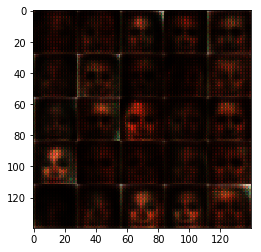

Epoch 1/1... batch 210... Discriminator Loss: 0.8812... Generator Loss: 2.3821
Epoch 1/1... batch 220... Discriminator Loss: 1.4597... Generator Loss: 3.9750
Epoch 1/1... batch 230... Discriminator Loss: 1.1495... Generator Loss: 3.7491
Epoch 1/1... batch 240... Discriminator Loss: 2.1550... Generator Loss: 1.6256
Epoch 1/1... batch 250... Discriminator Loss: 1.6355... Generator Loss: 1.9253
Epoch 1/1... batch 260... Discriminator Loss: 1.8276... Generator Loss: 2.4411
Epoch 1/1... batch 270... Discriminator Loss: 1.4613... Generator Loss: 2.5317
Epoch 1/1... batch 280... Discriminator Loss: 1.0620... Generator Loss: 0.7407
Epoch 1/1... batch 290... Discriminator Loss: 1.3789... Generator Loss: 1.1830
Epoch 1/1... batch 300... Discriminator Loss: 1.5898... Generator Loss: 1.8798


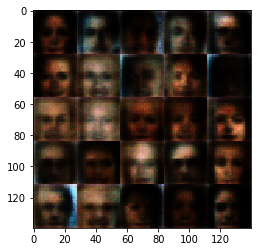

Epoch 1/1... batch 310... Discriminator Loss: 0.7095... Generator Loss: 1.6355
Epoch 1/1... batch 320... Discriminator Loss: 1.5610... Generator Loss: 1.0790
Epoch 1/1... batch 330... Discriminator Loss: 1.4169... Generator Loss: 0.4750
Epoch 1/1... batch 340... Discriminator Loss: 1.4343... Generator Loss: 0.4831
Epoch 1/1... batch 350... Discriminator Loss: 1.8152... Generator Loss: 0.2866
Epoch 1/1... batch 360... Discriminator Loss: 2.2902... Generator Loss: 0.1727
Epoch 1/1... batch 370... Discriminator Loss: 1.4466... Generator Loss: 3.1130
Epoch 1/1... batch 380... Discriminator Loss: 1.2886... Generator Loss: 2.3267
Epoch 1/1... batch 390... Discriminator Loss: 1.6282... Generator Loss: 0.3883
Epoch 1/1... batch 400... Discriminator Loss: 1.4661... Generator Loss: 0.4898


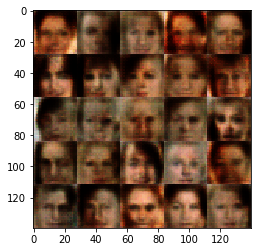

Epoch 1/1... batch 410... Discriminator Loss: 0.5685... Generator Loss: 1.8661
Epoch 1/1... batch 420... Discriminator Loss: 3.1245... Generator Loss: 3.1186
Epoch 1/1... batch 430... Discriminator Loss: 1.5972... Generator Loss: 1.0693
Epoch 1/1... batch 440... Discriminator Loss: 1.2712... Generator Loss: 0.5579
Epoch 1/1... batch 450... Discriminator Loss: 1.4373... Generator Loss: 0.4459
Epoch 1/1... batch 460... Discriminator Loss: 0.8477... Generator Loss: 2.8089
Epoch 1/1... batch 470... Discriminator Loss: 1.1312... Generator Loss: 2.0547
Epoch 1/1... batch 480... Discriminator Loss: 1.0747... Generator Loss: 0.7192
Epoch 1/1... batch 490... Discriminator Loss: 1.3286... Generator Loss: 0.6112
Epoch 1/1... batch 500... Discriminator Loss: 1.3950... Generator Loss: 0.5146


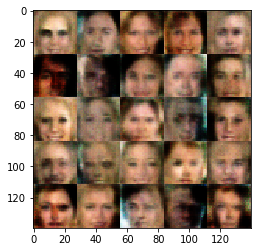

Epoch 1/1... batch 510... Discriminator Loss: 1.4914... Generator Loss: 1.9530
Epoch 1/1... batch 520... Discriminator Loss: 1.5676... Generator Loss: 3.1447
Epoch 1/1... batch 530... Discriminator Loss: 1.0978... Generator Loss: 2.6575
Epoch 1/1... batch 540... Discriminator Loss: 1.2679... Generator Loss: 2.5910
Epoch 1/1... batch 550... Discriminator Loss: 0.8075... Generator Loss: 2.1606
Epoch 1/1... batch 560... Discriminator Loss: 1.4416... Generator Loss: 1.7303
Epoch 1/1... batch 570... Discriminator Loss: 0.8079... Generator Loss: 1.3013
Epoch 1/1... batch 580... Discriminator Loss: 1.5293... Generator Loss: 0.4252
Epoch 1/1... batch 590... Discriminator Loss: 1.7350... Generator Loss: 2.2453
Epoch 1/1... batch 600... Discriminator Loss: 0.8783... Generator Loss: 1.2269


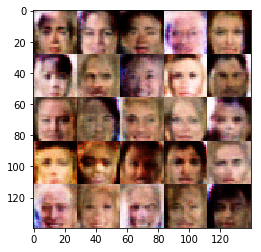

Epoch 1/1... batch 610... Discriminator Loss: 0.7912... Generator Loss: 1.2189
Epoch 1/1... batch 620... Discriminator Loss: 1.3606... Generator Loss: 1.0480
Epoch 1/1... batch 630... Discriminator Loss: 1.3773... Generator Loss: 1.6532
Epoch 1/1... batch 640... Discriminator Loss: 1.4829... Generator Loss: 1.1915
Epoch 1/1... batch 650... Discriminator Loss: 2.0410... Generator Loss: 2.6109
Epoch 1/1... batch 660... Discriminator Loss: 1.3291... Generator Loss: 0.5529
Epoch 1/1... batch 670... Discriminator Loss: 1.4969... Generator Loss: 0.4156
Epoch 1/1... batch 680... Discriminator Loss: 0.7735... Generator Loss: 1.1872
Epoch 1/1... batch 690... Discriminator Loss: 2.2465... Generator Loss: 2.3041
Epoch 1/1... batch 700... Discriminator Loss: 1.2506... Generator Loss: 0.6924


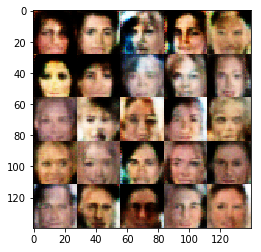

Epoch 1/1... batch 710... Discriminator Loss: 1.3023... Generator Loss: 0.5138
Epoch 1/1... batch 720... Discriminator Loss: 0.9629... Generator Loss: 1.0380
Epoch 1/1... batch 730... Discriminator Loss: 1.1763... Generator Loss: 1.0916
Epoch 1/1... batch 740... Discriminator Loss: 1.3748... Generator Loss: 1.0971
Epoch 1/1... batch 750... Discriminator Loss: 0.8039... Generator Loss: 2.6188
Epoch 1/1... batch 760... Discriminator Loss: 1.2107... Generator Loss: 0.6640
Epoch 1/1... batch 770... Discriminator Loss: 1.1980... Generator Loss: 0.6397
Epoch 1/1... batch 780... Discriminator Loss: 2.0116... Generator Loss: 0.2353
Epoch 1/1... batch 790... Discriminator Loss: 1.5476... Generator Loss: 0.6908
Epoch 1/1... batch 800... Discriminator Loss: 1.4432... Generator Loss: 1.8948


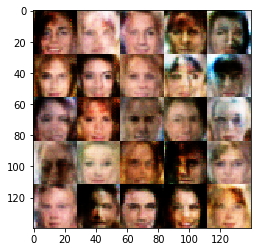

Epoch 1/1... batch 810... Discriminator Loss: 1.2816... Generator Loss: 1.0900
Epoch 1/1... batch 820... Discriminator Loss: 1.1030... Generator Loss: 0.7296
Epoch 1/1... batch 830... Discriminator Loss: 1.6398... Generator Loss: 1.7786
Epoch 1/1... batch 840... Discriminator Loss: 1.0196... Generator Loss: 1.5681
Epoch 1/1... batch 850... Discriminator Loss: 1.6265... Generator Loss: 0.3845
Epoch 1/1... batch 860... Discriminator Loss: 1.7082... Generator Loss: 2.2243
Epoch 1/1... batch 870... Discriminator Loss: 1.5376... Generator Loss: 2.1641
Epoch 1/1... batch 880... Discriminator Loss: 1.0806... Generator Loss: 1.8869
Epoch 1/1... batch 890... Discriminator Loss: 1.3350... Generator Loss: 1.6288
Epoch 1/1... batch 900... Discriminator Loss: 1.0816... Generator Loss: 2.0887


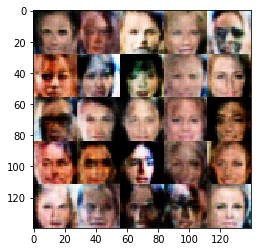

Epoch 1/1... batch 910... Discriminator Loss: 0.6966... Generator Loss: 2.2296
Epoch 1/1... batch 920... Discriminator Loss: 0.8400... Generator Loss: 2.0950
Epoch 1/1... batch 930... Discriminator Loss: 1.5598... Generator Loss: 1.9432
Epoch 1/1... batch 940... Discriminator Loss: 1.3889... Generator Loss: 0.4949
Epoch 1/1... batch 950... Discriminator Loss: 1.7767... Generator Loss: 0.2845
Epoch 1/1... batch 960... Discriminator Loss: 0.9454... Generator Loss: 2.7009
Epoch 1/1... batch 970... Discriminator Loss: 1.1016... Generator Loss: 2.1768
Epoch 1/1... batch 980... Discriminator Loss: 1.3647... Generator Loss: 0.5931
Epoch 1/1... batch 990... Discriminator Loss: 1.0221... Generator Loss: 0.7474
Epoch 1/1... batch 1000... Discriminator Loss: 1.3204... Generator Loss: 0.5966


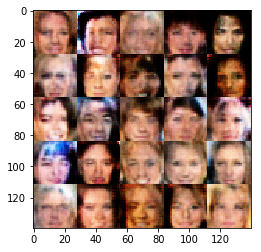

Epoch 1/1... batch 1010... Discriminator Loss: 0.7944... Generator Loss: 1.2640
Epoch 1/1... batch 1020... Discriminator Loss: 0.8400... Generator Loss: 2.4795
Epoch 1/1... batch 1030... Discriminator Loss: 0.8344... Generator Loss: 1.1787
Epoch 1/1... batch 1040... Discriminator Loss: 1.8529... Generator Loss: 0.2736
Epoch 1/1... batch 1050... Discriminator Loss: 1.4069... Generator Loss: 0.4727
Epoch 1/1... batch 1060... Discriminator Loss: 0.6922... Generator Loss: 1.5031
Epoch 1/1... batch 1070... Discriminator Loss: 0.8059... Generator Loss: 1.3376
Epoch 1/1... batch 1080... Discriminator Loss: 1.4439... Generator Loss: 0.4444
Epoch 1/1... batch 1090... Discriminator Loss: 1.1248... Generator Loss: 2.3290
Epoch 1/1... batch 1100... Discriminator Loss: 1.1423... Generator Loss: 1.5010


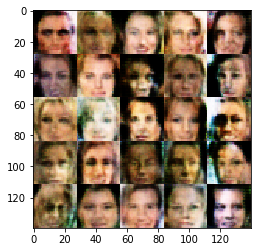

Epoch 1/1... batch 1110... Discriminator Loss: 1.0939... Generator Loss: 1.7883
Epoch 1/1... batch 1120... Discriminator Loss: 1.5479... Generator Loss: 2.1417
Epoch 1/1... batch 1130... Discriminator Loss: 1.6334... Generator Loss: 1.7623
Epoch 1/1... batch 1140... Discriminator Loss: 1.2637... Generator Loss: 2.4382
Epoch 1/1... batch 1150... Discriminator Loss: 1.0984... Generator Loss: 1.0968
Epoch 1/1... batch 1160... Discriminator Loss: 1.7839... Generator Loss: 0.2916
Epoch 1/1... batch 1170... Discriminator Loss: 1.3286... Generator Loss: 0.5333
Epoch 1/1... batch 1180... Discriminator Loss: 1.2064... Generator Loss: 0.6205
Epoch 1/1... batch 1190... Discriminator Loss: 0.9550... Generator Loss: 1.6872
Epoch 1/1... batch 1200... Discriminator Loss: 1.1029... Generator Loss: 0.7243


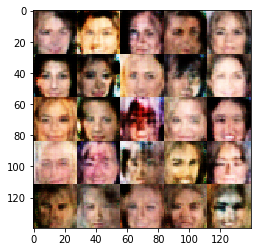

Epoch 1/1... batch 1210... Discriminator Loss: 0.9565... Generator Loss: 0.8379
Epoch 1/1... batch 1220... Discriminator Loss: 1.9606... Generator Loss: 0.2380
Epoch 1/1... batch 1230... Discriminator Loss: 1.2919... Generator Loss: 0.5373
Epoch 1/1... batch 1240... Discriminator Loss: 0.7252... Generator Loss: 1.4693
Epoch 1/1... batch 1250... Discriminator Loss: 1.9845... Generator Loss: 0.2409
Epoch 1/1... batch 1260... Discriminator Loss: 1.7656... Generator Loss: 2.2615
Epoch 1/1... batch 1270... Discriminator Loss: 0.5911... Generator Loss: 1.8996
Epoch 1/1... batch 1280... Discriminator Loss: 2.7751... Generator Loss: 3.3323
Epoch 1/1... batch 1290... Discriminator Loss: 1.2331... Generator Loss: 0.5804
Epoch 1/1... batch 1300... Discriminator Loss: 1.1418... Generator Loss: 0.7952


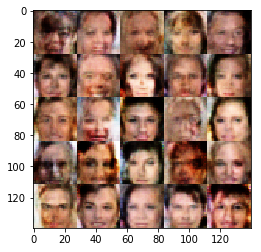

Epoch 1/1... batch 1310... Discriminator Loss: 1.4825... Generator Loss: 0.4652
Epoch 1/1... batch 1320... Discriminator Loss: 1.1824... Generator Loss: 2.2425
Epoch 1/1... batch 1330... Discriminator Loss: 1.0324... Generator Loss: 0.8592
Epoch 1/1... batch 1340... Discriminator Loss: 1.3879... Generator Loss: 0.7086
Epoch 1/1... batch 1350... Discriminator Loss: 1.1430... Generator Loss: 1.0877
Epoch 1/1... batch 1360... Discriminator Loss: 1.3961... Generator Loss: 0.5422
Epoch 1/1... batch 1370... Discriminator Loss: 1.1316... Generator Loss: 1.0685
Epoch 1/1... batch 1380... Discriminator Loss: 0.8132... Generator Loss: 1.9978
Epoch 1/1... batch 1390... Discriminator Loss: 1.4687... Generator Loss: 1.6933
Epoch 1/1... batch 1400... Discriminator Loss: 0.7805... Generator Loss: 1.1923


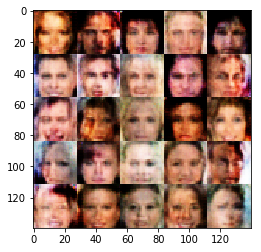

Epoch 1/1... batch 1410... Discriminator Loss: 2.5950... Generator Loss: 0.1206
Epoch 1/1... batch 1420... Discriminator Loss: 0.8317... Generator Loss: 1.4983
Epoch 1/1... batch 1430... Discriminator Loss: 1.0930... Generator Loss: 0.7031
Epoch 1/1... batch 1440... Discriminator Loss: 2.5531... Generator Loss: 2.6826
Epoch 1/1... batch 1450... Discriminator Loss: 0.8658... Generator Loss: 0.9849
Epoch 1/1... batch 1460... Discriminator Loss: 1.0777... Generator Loss: 1.6420
Epoch 1/1... batch 1470... Discriminator Loss: 0.6870... Generator Loss: 2.4434
Epoch 1/1... batch 1480... Discriminator Loss: 0.8805... Generator Loss: 1.5601
Epoch 1/1... batch 1490... Discriminator Loss: 0.9906... Generator Loss: 1.4991
Epoch 1/1... batch 1500... Discriminator Loss: 0.7299... Generator Loss: 2.1986


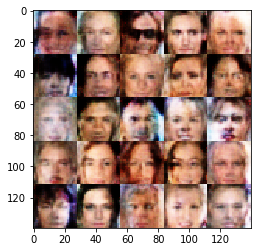

Epoch 1/1... batch 1510... Discriminator Loss: 1.6916... Generator Loss: 1.0399
Epoch 1/1... batch 1520... Discriminator Loss: 1.1852... Generator Loss: 2.3914
Epoch 1/1... batch 1530... Discriminator Loss: 1.5209... Generator Loss: 1.3187
Epoch 1/1... batch 1540... Discriminator Loss: 1.3625... Generator Loss: 0.9162
Epoch 1/1... batch 1550... Discriminator Loss: 1.3080... Generator Loss: 1.4841
Epoch 1/1... batch 1560... Discriminator Loss: 1.4025... Generator Loss: 1.6023
Epoch 1/1... batch 1570... Discriminator Loss: 0.8389... Generator Loss: 1.6491
Epoch 1/1... batch 1580... Discriminator Loss: 0.9475... Generator Loss: 1.0788
Epoch 1/1... batch 1590... Discriminator Loss: 1.3596... Generator Loss: 0.5222
Epoch 1/1... batch 1600... Discriminator Loss: 0.9593... Generator Loss: 1.2018


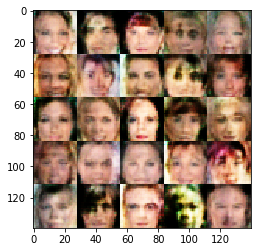

Epoch 1/1... batch 1610... Discriminator Loss: 1.4250... Generator Loss: 0.5241
Epoch 1/1... batch 1620... Discriminator Loss: 1.5540... Generator Loss: 0.5353
Epoch 1/1... batch 1630... Discriminator Loss: 1.2820... Generator Loss: 2.0954
Epoch 1/1... batch 1640... Discriminator Loss: 0.8293... Generator Loss: 1.2681
Epoch 1/1... batch 1650... Discriminator Loss: 1.5082... Generator Loss: 0.4226
Epoch 1/1... batch 1660... Discriminator Loss: 1.2385... Generator Loss: 0.5664
Epoch 1/1... batch 1670... Discriminator Loss: 1.5277... Generator Loss: 1.4575
Epoch 1/1... batch 1680... Discriminator Loss: 1.7248... Generator Loss: 1.8909
Epoch 1/1... batch 1690... Discriminator Loss: 1.4408... Generator Loss: 1.8141
Epoch 1/1... batch 1700... Discriminator Loss: 0.8652... Generator Loss: 2.9393


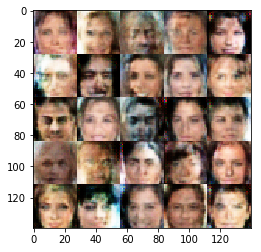

Epoch 1/1... batch 1710... Discriminator Loss: 1.4602... Generator Loss: 1.9959
Epoch 1/1... batch 1720... Discriminator Loss: 0.9671... Generator Loss: 0.9434
Epoch 1/1... batch 1730... Discriminator Loss: 1.2341... Generator Loss: 1.0066
Epoch 1/1... batch 1740... Discriminator Loss: 1.1928... Generator Loss: 1.6037
Epoch 1/1... batch 1750... Discriminator Loss: 0.9993... Generator Loss: 1.0687
Epoch 1/1... batch 1760... Discriminator Loss: 1.2044... Generator Loss: 0.6597
Epoch 1/1... batch 1770... Discriminator Loss: 2.0778... Generator Loss: 2.3067
Epoch 1/1... batch 1780... Discriminator Loss: 1.6074... Generator Loss: 0.3612
Epoch 1/1... batch 1790... Discriminator Loss: 0.8667... Generator Loss: 2.2945
Epoch 1/1... batch 1800... Discriminator Loss: 1.3613... Generator Loss: 0.8962


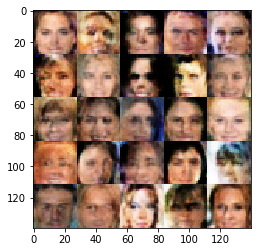

Epoch 1/1... batch 1810... Discriminator Loss: 0.8297... Generator Loss: 2.7714
Epoch 1/1... batch 1820... Discriminator Loss: 1.4773... Generator Loss: 0.4524
Epoch 1/1... batch 1830... Discriminator Loss: 1.4049... Generator Loss: 0.5117
Epoch 1/1... batch 1840... Discriminator Loss: 1.4610... Generator Loss: 0.4672
Epoch 1/1... batch 1850... Discriminator Loss: 1.7728... Generator Loss: 1.5812
Epoch 1/1... batch 1860... Discriminator Loss: 0.9803... Generator Loss: 1.2445
Epoch 1/1... batch 1870... Discriminator Loss: 1.5820... Generator Loss: 2.0402
Epoch 1/1... batch 1880... Discriminator Loss: 1.1746... Generator Loss: 0.6625
Epoch 1/1... batch 1890... Discriminator Loss: 0.7178... Generator Loss: 1.3296
Epoch 1/1... batch 1900... Discriminator Loss: 1.6336... Generator Loss: 1.6467


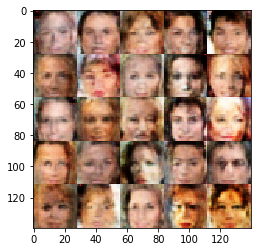

Epoch 1/1... batch 1910... Discriminator Loss: 1.0489... Generator Loss: 0.7663
Epoch 1/1... batch 1920... Discriminator Loss: 1.0667... Generator Loss: 0.8290
Epoch 1/1... batch 1930... Discriminator Loss: 1.3442... Generator Loss: 0.5233
Epoch 1/1... batch 1940... Discriminator Loss: 0.8615... Generator Loss: 1.0756
Epoch 1/1... batch 1950... Discriminator Loss: 1.7276... Generator Loss: 0.3153
Epoch 1/1... batch 1960... Discriminator Loss: 1.3228... Generator Loss: 1.0278
Epoch 1/1... batch 1970... Discriminator Loss: 1.2728... Generator Loss: 1.3735
Epoch 1/1... batch 1980... Discriminator Loss: 1.2552... Generator Loss: 1.7185
Epoch 1/1... batch 1990... Discriminator Loss: 1.3277... Generator Loss: 1.4753
Epoch 1/1... batch 2000... Discriminator Loss: 1.1657... Generator Loss: 0.6963


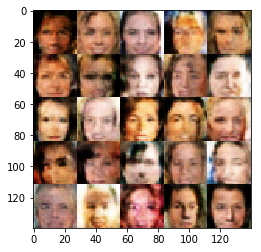

Epoch 1/1... batch 2010... Discriminator Loss: 1.5794... Generator Loss: 0.4140
Epoch 1/1... batch 2020... Discriminator Loss: 1.1297... Generator Loss: 0.6809
Epoch 1/1... batch 2030... Discriminator Loss: 1.0076... Generator Loss: 2.0273
Epoch 1/1... batch 2040... Discriminator Loss: 1.3360... Generator Loss: 0.8075
Epoch 1/1... batch 2050... Discriminator Loss: 0.9811... Generator Loss: 2.2025
Epoch 1/1... batch 2060... Discriminator Loss: 0.7639... Generator Loss: 1.7376
Epoch 1/1... batch 2070... Discriminator Loss: 1.7461... Generator Loss: 0.3382
Epoch 1/1... batch 2080... Discriminator Loss: 1.4037... Generator Loss: 0.4609
Epoch 1/1... batch 2090... Discriminator Loss: 1.1516... Generator Loss: 0.6369
Epoch 1/1... batch 2100... Discriminator Loss: 1.0280... Generator Loss: 0.8676


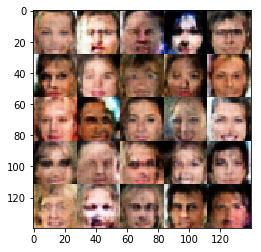

Epoch 1/1... batch 2110... Discriminator Loss: 0.6583... Generator Loss: 1.6187
Epoch 1/1... batch 2120... Discriminator Loss: 1.0775... Generator Loss: 2.0973
Epoch 1/1... batch 2130... Discriminator Loss: 1.4455... Generator Loss: 1.6440
Epoch 1/1... batch 2140... Discriminator Loss: 1.6927... Generator Loss: 0.3380
Epoch 1/1... batch 2150... Discriminator Loss: 1.3663... Generator Loss: 0.5366
Epoch 1/1... batch 2160... Discriminator Loss: 1.9048... Generator Loss: 0.2599
Epoch 1/1... batch 2170... Discriminator Loss: 1.2791... Generator Loss: 1.1096
Epoch 1/1... batch 2180... Discriminator Loss: 1.2487... Generator Loss: 1.8076
Epoch 1/1... batch 2190... Discriminator Loss: 0.8946... Generator Loss: 0.9980
Epoch 1/1... batch 2200... Discriminator Loss: 1.3368... Generator Loss: 1.1890


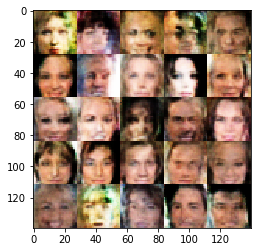

Epoch 1/1... batch 2210... Discriminator Loss: 1.1330... Generator Loss: 0.8277
Epoch 1/1... batch 2220... Discriminator Loss: 1.2287... Generator Loss: 0.7326
Epoch 1/1... batch 2230... Discriminator Loss: 0.6501... Generator Loss: 1.4465
Epoch 1/1... batch 2240... Discriminator Loss: 1.0672... Generator Loss: 1.2996
Epoch 1/1... batch 2250... Discriminator Loss: 1.5988... Generator Loss: 1.6461
Epoch 1/1... batch 2260... Discriminator Loss: 1.4276... Generator Loss: 0.9427
Epoch 1/1... batch 2270... Discriminator Loss: 1.1847... Generator Loss: 0.6603
Epoch 1/1... batch 2280... Discriminator Loss: 1.5929... Generator Loss: 0.3620
Epoch 1/1... batch 2290... Discriminator Loss: 1.6141... Generator Loss: 0.3747
Epoch 1/1... batch 2300... Discriminator Loss: 0.6948... Generator Loss: 1.9967


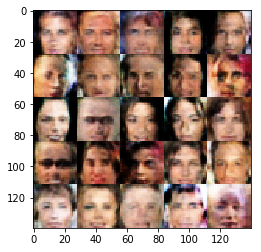

Epoch 1/1... batch 2310... Discriminator Loss: 1.3502... Generator Loss: 1.3640
Epoch 1/1... batch 2320... Discriminator Loss: 1.6267... Generator Loss: 1.7319
Epoch 1/1... batch 2330... Discriminator Loss: 0.9178... Generator Loss: 1.4143
Epoch 1/1... batch 2340... Discriminator Loss: 1.2244... Generator Loss: 1.1604
Epoch 1/1... batch 2350... Discriminator Loss: 1.2361... Generator Loss: 0.7882
Epoch 1/1... batch 2360... Discriminator Loss: 1.2709... Generator Loss: 0.6130
Epoch 1/1... batch 2370... Discriminator Loss: 1.4826... Generator Loss: 1.9409
Epoch 1/1... batch 2380... Discriminator Loss: 1.1070... Generator Loss: 2.8667
Epoch 1/1... batch 2390... Discriminator Loss: 0.6115... Generator Loss: 2.1390
Epoch 1/1... batch 2400... Discriminator Loss: 1.3707... Generator Loss: 0.6966


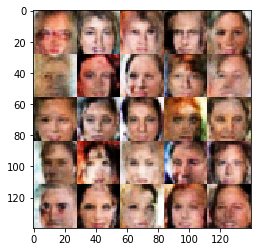

Epoch 1/1... batch 2410... Discriminator Loss: 1.3851... Generator Loss: 0.6396
Epoch 1/1... batch 2420... Discriminator Loss: 1.1703... Generator Loss: 0.8347
Epoch 1/1... batch 2430... Discriminator Loss: 1.1829... Generator Loss: 0.6819
Epoch 1/1... batch 2440... Discriminator Loss: 2.4183... Generator Loss: 2.7879
Epoch 1/1... batch 2450... Discriminator Loss: 0.7747... Generator Loss: 2.0273
Epoch 1/1... batch 2460... Discriminator Loss: 1.5957... Generator Loss: 1.6698
Epoch 1/1... batch 2470... Discriminator Loss: 1.1875... Generator Loss: 0.6709
Epoch 1/1... batch 2480... Discriminator Loss: 1.4168... Generator Loss: 0.5752
Epoch 1/1... batch 2490... Discriminator Loss: 0.9810... Generator Loss: 1.2552
Epoch 1/1... batch 2500... Discriminator Loss: 1.1605... Generator Loss: 1.5724


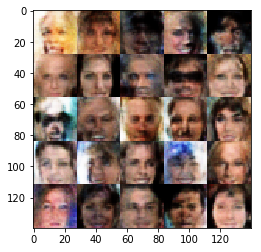

Epoch 1/1... batch 2510... Discriminator Loss: 1.5337... Generator Loss: 1.8604
Epoch 1/1... batch 2520... Discriminator Loss: 1.1175... Generator Loss: 1.0514
Epoch 1/1... batch 2530... Discriminator Loss: 1.3675... Generator Loss: 1.1285
Epoch 1/1... batch 2540... Discriminator Loss: 0.9746... Generator Loss: 0.8001
Epoch 1/1... batch 2550... Discriminator Loss: 1.2792... Generator Loss: 1.6699
Epoch 1/1... batch 2560... Discriminator Loss: 1.3229... Generator Loss: 0.6189
Epoch 1/1... batch 2570... Discriminator Loss: 1.4816... Generator Loss: 1.6913
Epoch 1/1... batch 2580... Discriminator Loss: 1.0042... Generator Loss: 1.2471
Epoch 1/1... batch 2590... Discriminator Loss: 1.1356... Generator Loss: 0.7085
Epoch 1/1... batch 2600... Discriminator Loss: 1.3798... Generator Loss: 0.5298


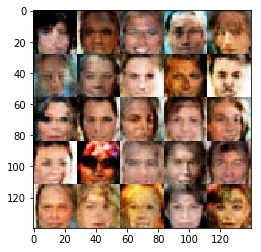

Epoch 1/1... batch 2610... Discriminator Loss: 1.2271... Generator Loss: 1.3860
Epoch 1/1... batch 2620... Discriminator Loss: 1.0713... Generator Loss: 2.0532
Epoch 1/1... batch 2630... Discriminator Loss: 1.7570... Generator Loss: 0.3402
Epoch 1/1... batch 2640... Discriminator Loss: 1.6635... Generator Loss: 1.5971
Epoch 1/1... batch 2650... Discriminator Loss: 1.1661... Generator Loss: 1.5444
Epoch 1/1... batch 2660... Discriminator Loss: 1.2064... Generator Loss: 1.3560
Epoch 1/1... batch 2670... Discriminator Loss: 1.0790... Generator Loss: 0.6923
Epoch 1/1... batch 2680... Discriminator Loss: 1.4482... Generator Loss: 0.6914
Epoch 1/1... batch 2690... Discriminator Loss: 0.8105... Generator Loss: 1.0958
Epoch 1/1... batch 2700... Discriminator Loss: 2.7709... Generator Loss: 3.0107


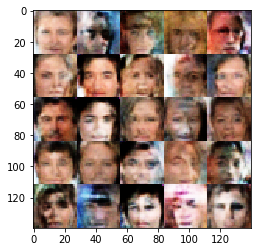

Epoch 1/1... batch 2710... Discriminator Loss: 1.3595... Generator Loss: 0.8289
Epoch 1/1... batch 2720... Discriminator Loss: 1.0361... Generator Loss: 0.7864
Epoch 1/1... batch 2730... Discriminator Loss: 1.5648... Generator Loss: 2.1720
Epoch 1/1... batch 2740... Discriminator Loss: 1.0098... Generator Loss: 0.8243
Epoch 1/1... batch 2750... Discriminator Loss: 1.3578... Generator Loss: 0.5741
Epoch 1/1... batch 2760... Discriminator Loss: 1.5386... Generator Loss: 2.3239
Epoch 1/1... batch 2770... Discriminator Loss: 1.5629... Generator Loss: 0.3834
Epoch 1/1... batch 2780... Discriminator Loss: 1.8554... Generator Loss: 0.3094
Epoch 1/1... batch 2790... Discriminator Loss: 0.8533... Generator Loss: 1.9988
Epoch 1/1... batch 2800... Discriminator Loss: 1.2990... Generator Loss: 1.6394


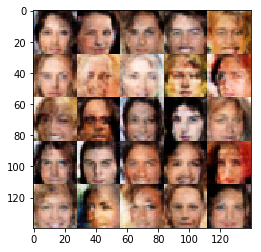

Epoch 1/1... batch 2810... Discriminator Loss: 0.9808... Generator Loss: 2.0179
Epoch 1/1... batch 2820... Discriminator Loss: 1.2584... Generator Loss: 0.7874
Epoch 1/1... batch 2830... Discriminator Loss: 0.8474... Generator Loss: 1.4735
Epoch 1/1... batch 2840... Discriminator Loss: 1.2717... Generator Loss: 0.8010
Epoch 1/1... batch 2850... Discriminator Loss: 1.0133... Generator Loss: 1.0879
Epoch 1/1... batch 2860... Discriminator Loss: 1.2785... Generator Loss: 0.8358
Epoch 1/1... batch 2870... Discriminator Loss: 0.7684... Generator Loss: 2.4578
Epoch 1/1... batch 2880... Discriminator Loss: 1.3836... Generator Loss: 0.5462
Epoch 1/1... batch 2890... Discriminator Loss: 0.8022... Generator Loss: 1.3368
Epoch 1/1... batch 2900... Discriminator Loss: 1.8933... Generator Loss: 0.2510


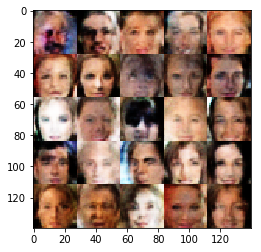

Epoch 1/1... batch 2910... Discriminator Loss: 1.1043... Generator Loss: 1.1410
Epoch 1/1... batch 2920... Discriminator Loss: 1.4222... Generator Loss: 0.5079
Epoch 1/1... batch 2930... Discriminator Loss: 2.3014... Generator Loss: 3.0001
Epoch 1/1... batch 2940... Discriminator Loss: 1.2640... Generator Loss: 1.1151
Epoch 1/1... batch 2950... Discriminator Loss: 1.2562... Generator Loss: 1.1692
Epoch 1/1... batch 2960... Discriminator Loss: 1.0493... Generator Loss: 1.1113
Epoch 1/1... batch 2970... Discriminator Loss: 1.1231... Generator Loss: 0.8638
Epoch 1/1... batch 2980... Discriminator Loss: 1.5377... Generator Loss: 1.7604
Epoch 1/1... batch 2990... Discriminator Loss: 1.4554... Generator Loss: 0.8550
Epoch 1/1... batch 3000... Discriminator Loss: 1.3992... Generator Loss: 1.3670


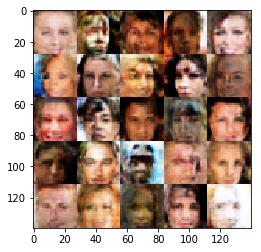

Epoch 1/1... batch 3010... Discriminator Loss: 1.5786... Generator Loss: 0.3977
Epoch 1/1... batch 3020... Discriminator Loss: 0.9800... Generator Loss: 1.0395
Epoch 1/1... batch 3030... Discriminator Loss: 1.3068... Generator Loss: 0.7420
Epoch 1/1... batch 3040... Discriminator Loss: 1.7613... Generator Loss: 0.3042
Epoch 1/1... batch 3050... Discriminator Loss: 1.2833... Generator Loss: 0.6518
Epoch 1/1... batch 3060... Discriminator Loss: 1.4852... Generator Loss: 0.4507
Epoch 1/1... batch 3070... Discriminator Loss: 0.9922... Generator Loss: 1.1051
Epoch 1/1... batch 3080... Discriminator Loss: 1.4362... Generator Loss: 2.9065
Epoch 1/1... batch 3090... Discriminator Loss: 1.0112... Generator Loss: 1.4521
Epoch 1/1... batch 3100... Discriminator Loss: 0.6646... Generator Loss: 1.5178


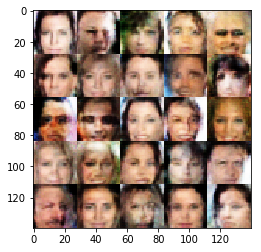

Epoch 1/1... batch 3110... Discriminator Loss: 1.3469... Generator Loss: 1.1680
Epoch 1/1... batch 3120... Discriminator Loss: 1.1710... Generator Loss: 0.6986
Epoch 1/1... batch 3130... Discriminator Loss: 1.3843... Generator Loss: 1.6420
Epoch 1/1... batch 3140... Discriminator Loss: 1.5809... Generator Loss: 1.7854
Epoch 1/1... batch 3150... Discriminator Loss: 1.6546... Generator Loss: 0.3422
Epoch 1/1... batch 3160... Discriminator Loss: 1.1481... Generator Loss: 2.2735


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.